In [3]:
!pip install -q seaborn

ERROR: snowflake-ml-python 1.0.1 has requirement packaging<24,>=20.9, but you'll have packaging 24.0 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement pandas<2,>=1.0.0, but you'll have pandas 2.0.3 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement snowflake-snowpark-python<2,>=1.4.0, but you'll have snowflake-snowpark-python 1.0.0 which is incompatible.
ERROR: openapi-spec-validator 0.7.1 has requirement jsonschema<5.0.0,>=4.18.0, but you'll have jsonschema 3.2.0 which is incompatible.
ERROR: openapi-schema-validator 0.6.2 has requirement jsonschema<5.0.0,>=4.19.1, but you'll have jsonschema 3.2.0 which is incompatible.
ERROR: mosaic-ai-serving 1.0.0 has requirement Flask==2.1.1; python_version >= "3.7", but you'll have flask 2.2.5 which is incompatible.
ERROR: mosaic-ai-serving 1.0.0 has requirement matplotlib==3.6.0; python_version >= "3.8", but you'll have matplotlib 3.7.5 which is incompatible.
ERROR: mosaic-ai-client 1.0.0 has requiremen

In [1]:
from snowflake.snowpark import Session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# create_temp_table warning suppresion
import warnings; warnings.simplefilter('ignore')
import configparser

Matplotlib created a temporary cache directory at /tmp/matplotlib-_tt0np4z because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Code to establish connection and read data from Snowflake

In [3]:
config = configparser.ConfigParser()
config.read("snowflake_connection.ini")

['snowflake_connection.ini']

In [4]:
connection_parameters = {
    "user": f'{config["Snowflake"]["user"]}',
    "password": f'{config["Snowflake"]["password"]}',
    #"password": os.getenv('snowflake_password'),
    "account": f'{config["Snowflake"]["account"]}',
    #"account": os.getenv('snowflake_account'),
    "WAREHOUSE": f'{config["Snowflake"]["WAREHOUSE"]}',
    "DATABASE": f'{config["Snowflake"]["DATABASE"]}',
    "SCHEMA": f'{config["Snowflake"]["SCHEMA"]}'
}

In [5]:
def snowflake_connector(conn):
    try:
        session = Session.builder.configs(conn).create()
        print("connection successful!")
    except:
        raise ValueError("error while connecting with db")
    return session

session = snowflake_connector(connection_parameters)

connection successful!


In [6]:
application_train_sf  = session.table("CRA_APPLICATION_TRAIN_DETAILS")
application_test_sf  = session.table("CRA_APPLICATION_TEST_DETAILS")
bureau_sf  = session.table("CRA_BUREAU_DETAILS")
bureau_balance_sf  = session.table("CRA_BUREAU_BALANCE_DETAILS")
credit_card_balance_sf  = session.table("CRA_CREDIT_CARD_BALANCE_DETAILS")
installments_payments_sf  = session.table("CRA_INSTALLMENTS_PAYMENTS_DETAILS")
previous_application_sf  = session.table("CRA_PREVIOUS_APPLICATION_DETAILS")
POS_CASH_balance_sf  = session.table("CRA_POS_CASH_BALANCE_DETAILS")

# Convert Snowflake data into Pandas dataframes

In [7]:
application_train = application_train_sf.to_pandas()

In [8]:
application_test = application_test_sf.to_pandas()

In [9]:
bureau = bureau_sf.to_pandas()

In [10]:
bureau_balance = bureau_balance_sf.to_pandas()

In [11]:
credit_card_balance = credit_card_balance_sf.to_pandas()

In [12]:
installments_payments = installments_payments_sf.to_pandas()

In [13]:
previous_application = previous_application_sf.to_pandas()

In [14]:
POS_CASH_balance = POS_CASH_balance_sf.to_pandas()

# Data Visualization/Exploratory Data Analysis

####  Loan types
##### Let's see the type of the loans taken and also, on a separate plot, the percent of the loans (by type of the loan) with TARGET value 1 (not returned loan).

In [15]:
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = application_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

In [16]:
def plot_distribution(var):
    
    i = 0
    t1 = application_train.loc[application_train['TARGET'] != 0]
    t0 = application_train.loc[application_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(12,12))

    for feature in var:
        i += 1
        plt.subplot(2,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

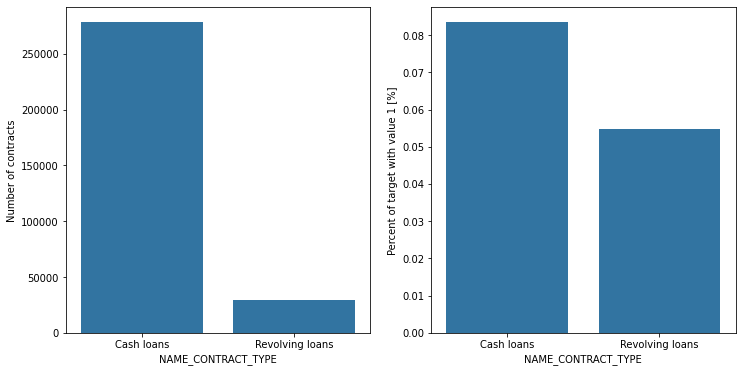

In [17]:
plot_stats('NAME_CONTRACT_TYPE')

Contract type Revolving loans are just a small fraction (10%) from the total number of loans; in the same time, a larger amount of Revolving loans, comparing with their frequency, are not repaid.

#### Client gender
##### Let's see the gender of the clients and also, on a separate plot, the percent of the loans (by client gender) with TARGET value 1 (not returned loan).

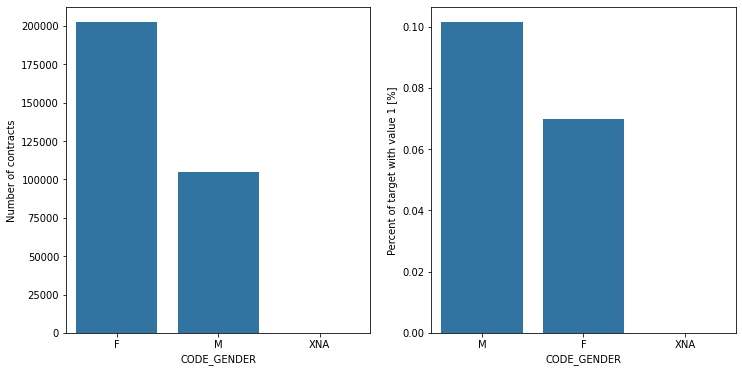

In [18]:
plot_stats('CODE_GENDER')

The number of female clients is almost double the number of male clients. Looking to the percent of defaulted credits, males have a higher chance of not returning their loans (approx 10%), comparing with women (approx 7%).

#### Flag own car and flag own real estate
##### Let's inspect the flags that tell us if a client owns a car or real estate and, on separate plots, the percent of the loans value of these flags) with TARGET value 1 (not returned loan).

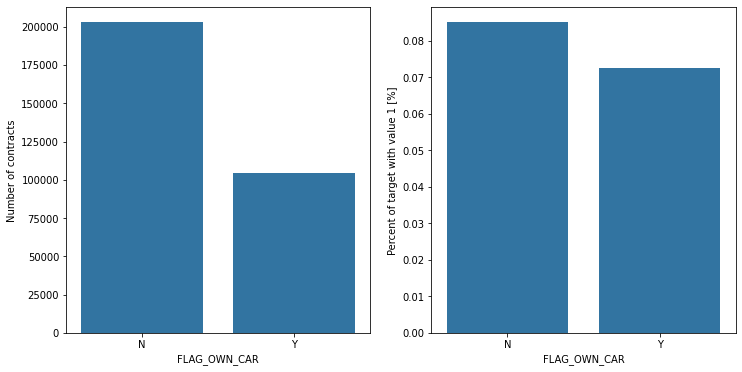

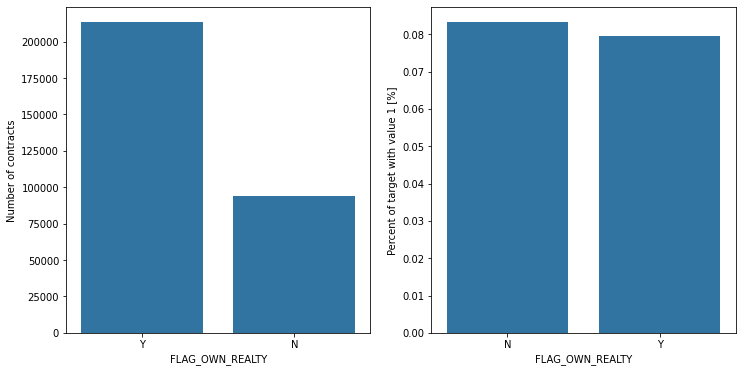

In [20]:
plot_stats('FLAG_OWN_CAR')
plot_stats('FLAG_OWN_REALTY')

The clients that owns a car are almost a half of the ones that doesn't own one. The clients that owns a car are less likely to not repay a car that the ones that own. Both categories have not-repayment rates around 8%.

The clients that owns real estate are more than double of the ones that doesn't own. Both categories (owning real estate or not owning) have not-repayment rates less than 8%.

#### Family Status

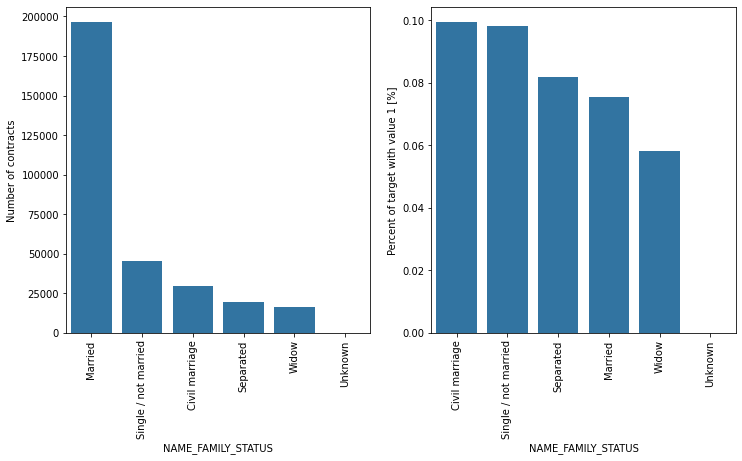

In [21]:
plot_stats('NAME_FAMILY_STATUS',True, True)

Most of clients are married, followed by Single/not married and civil marriage.

In terms of percentage of not repayment of loan, Civil marriage has the highest percent of not repayment (10%), with Widow the lowest (exception being Unknown).

#### Number of children 

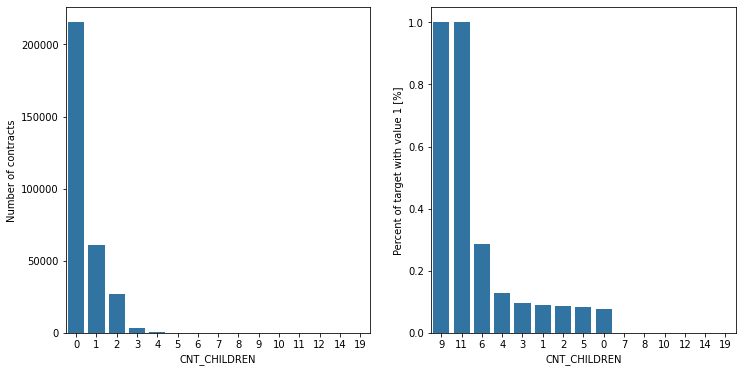

In [22]:
plot_stats('CNT_CHILDREN')

Most of the clients taking a loan have no children. The number of loans associated with the clients with one children are 4 times smaller, the number of loans associated with the clients with two children are 8 times smaller; clients with 3, 4 or more children are much more rare.

As for repayment, clients with no children, 1, 2, 3, and 5 children have percents of no repayment around the average (10%). The clients with 4 and 6 children are above average in terms of percent of not paid back loans (over 25% for families with 6 children).

As for clients with 9 or 11 children, the percent of loans not repaid is 100%.

#### Number of family members of client

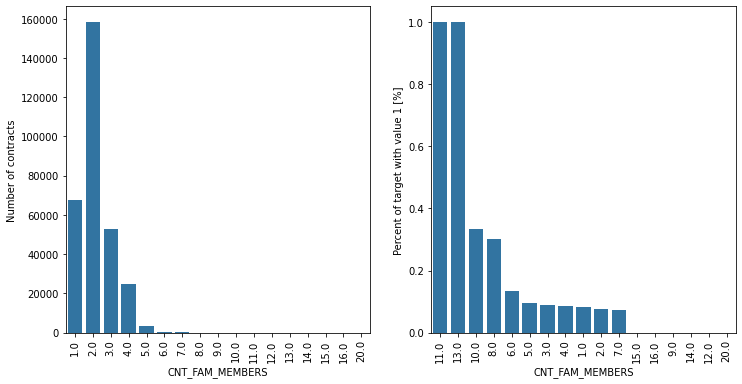

In [23]:
plot_stats('CNT_FAM_MEMBERS',True)

Clients with family members of 2 are most numerous, followed by 1 (single persons), 3 (families with one child) and 4.

Clients with family size of 11 and 13 have 100% not repayment rate. Other families with 10 or 8 members have percents of not repayment of loans over 30%. Families with 6 or less members have repayment rates close to the 10% average.

#### Income type of client
Let's investigate the numbers of clients with different income type. As well, let's see the percent of not returned loans per income type of applicants.

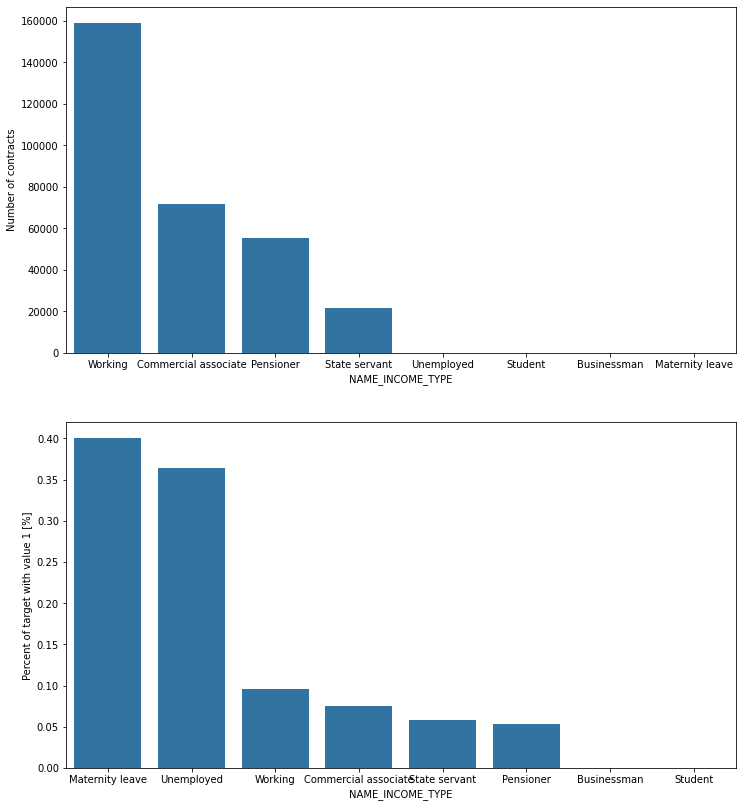

In [24]:
plot_stats('NAME_INCOME_TYPE',False,False)

Most of applicants for loans are income from Working, followed by Commercial associate, Pensioner and State servant.

The applicants with the type of income Maternity leave have almost 40% ratio of not returning loans, followed by Unemployed (37%). The rest of types of incomes are under the average of 10% for not returning loans.

#### Occupation of client

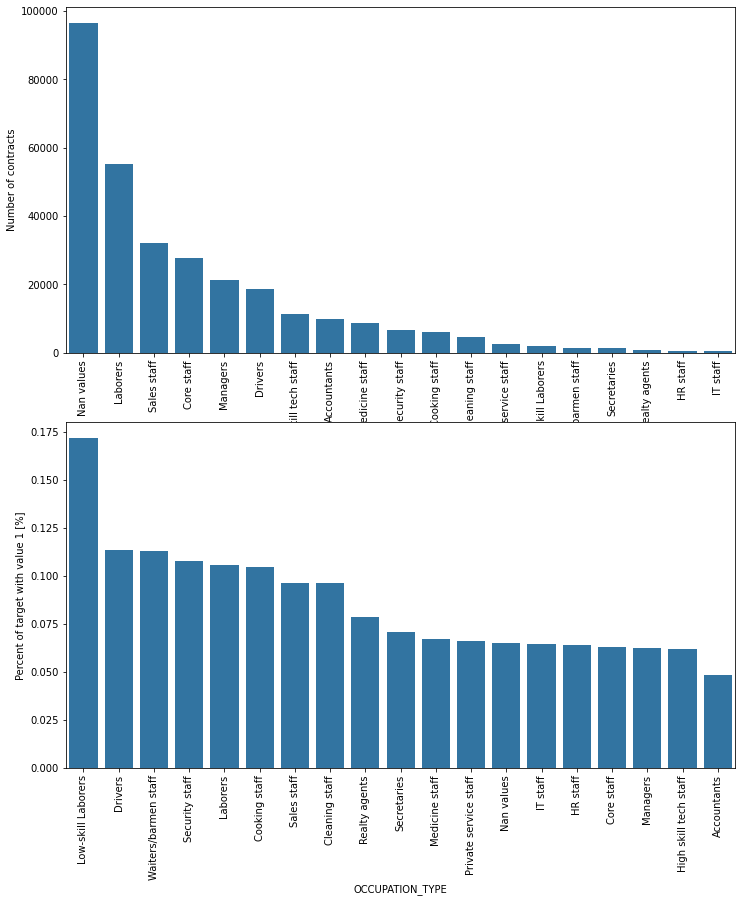

In [25]:
plot_stats('OCCUPATION_TYPE',True, False)

Most of the loans are taken by Laborers, followed by Sales staff. IT staff take the lowest amount of loans.

The category with highest percent of not repaid loans are Low-skill Laborers (above 17%), followed by Drivers and Waiters/barmen staff, Security staff, Laborers and Cooking staff.

#### Organization type of client

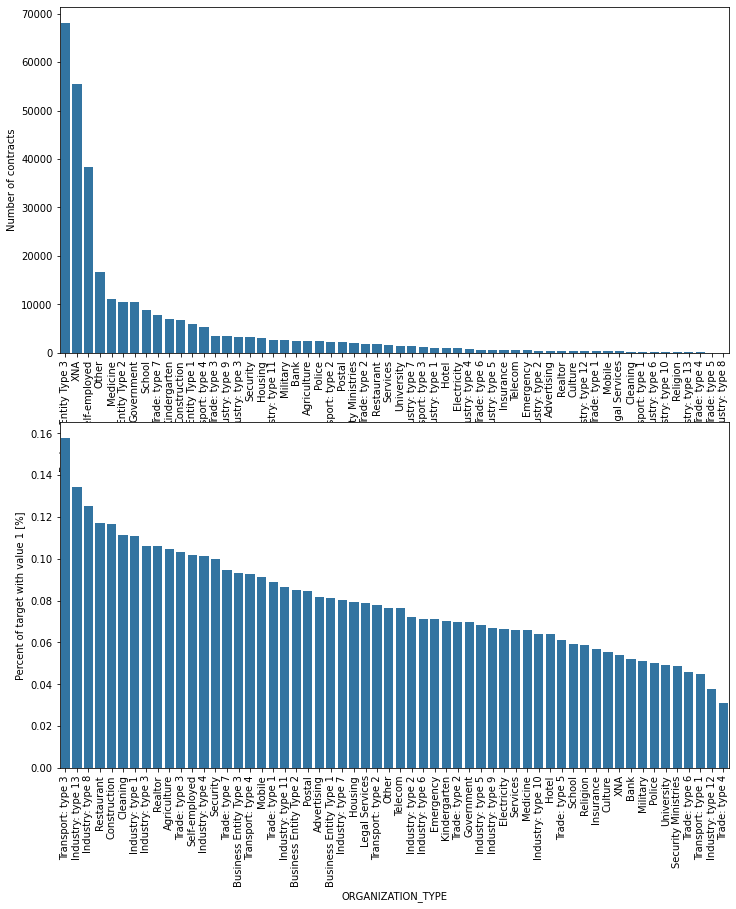

In [26]:
plot_stats('ORGANIZATION_TYPE',True, False)

Oraganizations with highest percent of loans not repaid are Transport: type 3 (16%), Industry: type 13 (13.5%), Industry: type 8 (12.5%) and Restaurant (less than 12%).

In [ ]:
####